In [1]:
def create_graph(corpus, deep=False):
    
    import networkx as nx
        
    G = nx.Graph()
    
    
    i = 0
    for text in corpus:
        
        print i
        
        
        try:
            entities = spot(text)
        
        except Exception as e:
            
            print e
            
            
            i+=1
            continue
        
        for entity in  entities:
            
            #print entity.keys()
                        
            #G.add_edge( i, entity['URI'], weight=entity['similarityScore'] )
            G.add_edge( text, entity['URI'], weight=entity['similarityScore'] )

            if deep:
            
                for node in ret_second_deg(entity['URI']):

                    G.add_edge(entity['URI'], node, weight=1)   
           
        
        i+=1
        
        
    return G

In [2]:
def load_corpus():
    from sklearn.datasets import fetch_20newsgroups
    newsgroups = fetch_20newsgroups(subset='all', remove=('headers','footers','quotes'))    
    return newsgroups
    

In [3]:
import cPickle as pkl

f = open("graph_20news_dbpedia_all_corrected.pkl")

entity_graph = pkl.load(f)

f.close()

In [4]:
print entity_graph

compose( ,  )


In [5]:
len(entity_graph.nodes())

29477

In [7]:
corpus = load_corpus()

In [6]:
 def create_solver(A, ml):

    ml.levels[0].A = A
    
    for i in range(len(ml.levels)-1):
        
        ml.levels[i+1].A = ml.levels[i].R * ml.levels[i].A * ml.levels[i].P 
        
    return ml   

In [1]:
#%%cython -a

class AS:
        
    
    def __init__(self, A, N,eta, w, pi, lab_pos, lab_neg,lab_warm,amg):
        
         
        import numpy as np
        from scipy.sparse import coo_matrix       

        from scipy.sparse import diags
        from scipy.sparse import identity
        self.lab_pos = lab_pos
        
        self.lab_neg = lab_neg
        
        self.lab_warm = lab_warm
        
        self.amg = amg
 
        self.N = N
        
        self.A = A

#       unlab = list( ( (set(range(N)) - set(lab_pos)) -set(lab_neg)) - set(lab_ign)  )

        lab = set(lab_pos) | set(lab_neg)| set(lab_warm)

        unlab = set(range(N)) - lab

        #convert A to matrix
    
          
       # setting D

        self.D = diags(np.squeeze(np.asarray(self.A.sum(axis =1))),0)


        #print "D is set"
        #D is set

        #setting B
        self.B = np.zeros(N)
        for i in range(N):

            if i in lab:

                self.B[i] = eta/(1-eta)
            if i in unlab:
                self.B[i] = 1./(1+w)

                
        #self.B = np.asmatrix(self.B)
        #print "B is set"        
        #B is set
        #setting I
        self.I = identity(N)
        #I is set
        #setting y
        
        self.y = np.zeros(N)
        
        for i in range(N):
            
            if i in lab_warm:

                self.y[i] = 0.5
            
            if i in lab_pos:

                self.y[i] = 1

            if i in lab_neg:

                self.y[i] = 0

            if i in unlab:
                self.y[i] = pi

	#self.y = np.asmatrix(self.y)
	
        #y is set

        #print "y is set"
    
	#convert to CSR
        print "converting to CSR"
        
        
        self.eta = eta
        self.w = w
        self.pi = pi
        #self.y = np.asmatrix(self.y)
        if True:
        
        #if  self.amg:

            self.A = coo_matrix(self.A)
            self.D = coo_matrix(self.D)
            #self.I = coo_matrix(np.identity(N))
#           self.B = coo_matrix(self.B)
#           self.y = coo_matrix(self.y)

            self.A = self.A.tocsr()
#           self.B = self.B.tocsr()
            self.D = self.D.tocsr()
#           self.y = self.y.tocsr()
            self.I = self.I.tocsr()

        print 'A:', self.A.shape
        print 'B:', self.B.shape
        print 'D:', self.D.shape
        print 'y:', self.y.shape
        print 'I:', self.I.shape

        print "converted"
    
    
    def update(self, index, label):
        
        #self.y = self.y.todense()
        
        #self.B = self.B.todense()
        
        
        if label == 'pos':
            
            self.lab_pos = self.lab_pos+[index,]
            
            self.y[index] = 1

        
        else:
            
            self.lab_neg = self.lab_neg+[index,]
            
            self.y[index] = 0

        
        from scipy.sparse import csr_matrix    
        
        
        
        self.B[index] = self.eta/(1.-self.eta)
            
                    
        #self.y = csr_matrix(self.y)
        import time
        
        #t = time.time()
        #self.B = csr_matrix(self.B)
        #print "mat conv", time.time()-t
        
    def search(self, itr=False):
        import numpy as np
    

        
        if self.amg:
            
            from pyamg import ruge_stuben_solver
            from scipy.sparse import diags
            
            tempB = diags([self.B.tolist()] , [0])
            tempy = self.y
            
            #self.C =  (self.D *  (self.I + self.B) ) -self.A

            self.C =  (self.D *  (self.I + tempB) ) -self.A
            
            
            #self.H = self.D *  (tempB * self.y.T)

            self.H = self.D * (tempB * tempy)
            
            #self.H = self.H.todense()
            
            self.H = np.asarray(self.H)

            
            ml = ruge_stuben_solver(self.C)
            
            self.ml = ml
            
            if  itr:
                solution = ml.solve(self.H, tol=0.5e-8, return_residuals=True)
                f = np.squeeze(solution[0])
                x = solution[1]
                
                return (f, x)
            
            else:
                f = np.squeeze(ml.solve(self.H, tol=0.5e-6))
                return f
                
 


        else:
                
            from scipy.sparse.linalg import spsolve

            self.C =  (self.D *  (self.I + self.B) ) -self.A

            self.H = self.D *  np.dot(np.diag(self.B) , self.y.T)
            
            #self.H = self.H.todense()
            
            #self.H = np.asarray(self.H)

            
            #ml = ruge_stuben_solver(self.C)
            
            #f = np.squeeze(ml.solve(self.H, tol=1e-4))
            

            f = np.squeeze(spsolve(self.C, self.H))
    
            return f
    
    def setCH(self):
        
        import numpy as np
        from pyamg import ruge_stuben_solver
        from scipy.sparse import diags
        
        tempB = diags([self.B.tolist()] , [0])
        tempy = self.y
            
        self.C =  (self.D *  (self.I + tempB) ) -self.A

            
            
        self.H = self.D * (tempB * tempy)

            
        #self.H = self.H.todense()
            
        self.H = np.asarray(self.H)
        


In [8]:
def largest_index(f, l):

    l = set(l)
    
    
    temp = -1.1
    idx = -1

    for i in range(len(f)):

        if i not in l:

            if f[i]>temp:
                
                temp = f[i]
                idx = i
            
    return idx    

In [9]:
class labels:
    
    def __init__(self, pos):
        
        self.pos = pos
            
    
    def __getitem__(self, query):
                
        if (query[8:]) in self.pos:

            return 1
        
        else:
            return 0
        

In [10]:
def find_node(G, target):
    
    i = -1
    
    for item in G.nodes():
        i+=1
        if item[:5] != "http:":
            
            continue
        
        if target.lower() in item.lower():
            
            print item, i
            


In [11]:
G = entity_graph

In [12]:
find_node(G, "graphics")

http://dbpedia.org/resource/3D_computer_graphics 1480
http://dbpedia.org/resource/Raster_graphics 1606
http://dbpedia.org/resource/Graphics_Interchange_Format 8797
http://dbpedia.org/resource/Vector_graphics 9625
http://dbpedia.org/resource/Rendering_(computer_graphics) 11524
http://dbpedia.org/resource/Graphics 15125
http://dbpedia.org/resource/Computer_graphics 15298
http://dbpedia.org/resource/Sprite_(computer_graphics) 16183
http://dbpedia.org/resource/Video_Graphics_Array 17038
http://dbpedia.org/resource/2D_computer_graphics 18513
http://dbpedia.org/resource/Demographics 20900
http://dbpedia.org/resource/Silicon_Graphics 20957
http://dbpedia.org/resource/Graphics_processing_unit 27522


In [13]:
def search_test_new_nofb(search,G ,itr=10):
        
    visited = []    
    
    countries = []
    
    out = search.search()
    
    ml = search.ml
    
    tot = 0
    
    plot = []
    
    for i in range(itr):
        
        if i%100 ==0:
            
            print "currently at itr:", i
        
        
    
        li = largest_index(out, visited)
        
        visited.append(li)
        
        countries.append(G.nodes()[li])
    

        
    return countries, out


In [15]:
import networkx as nx
A = nx.adjacency_matrix(G)

N = len(A.todense())
eta =0.5
w = .0000000000001/N
pi = 0.2


l_pos=[12936]
l_neg=[]
l_warm=[]


search = AS(A, N, eta, w, pi ,l_pos, l_neg, l_warm, amg=True)
output = search_test_new_nofb(search,G ,itr=20)

converting to CSR
A: (29477, 29477)
B: (29477,)
D: (29477, 29477)
y: (29477,)
I: (29477, 29477)
converted
currently at itr: 0


In [14]:
#from matplotlib import pyplot as plt

## OS & Open Source

converting to CSR
A: (29477, 29477)
B: (29477,)
D: (29477, 29477)
y: (29477,)
I: (29477, 29477)
converted
currently at itr: 0


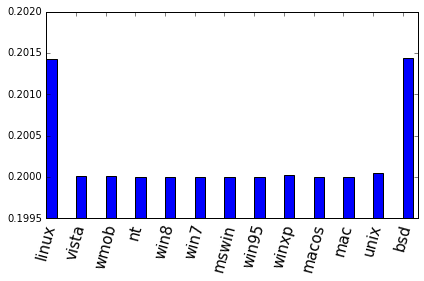

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt
import networkx as nx

A = nx.adjacency_matrix(G)

eta = 0.5

plt.figure(figsize=(8,6))
mgs = []

for i in range(1):


    N = len(A.todense())
    w = 1./N
    pi = 0.2

    l_pos=[13575,21477]
    l_neg=[]
    #l_neg=[19337]
    l_warm=[]


    search = AS(A, N, eta, w, pi ,l_pos, l_neg, l_warm, amg=True)
    output, out = search_test_new_nofb(search,G ,itr=1)
    
    eta= eta-0.08

%matplotlib inline
os = [15535,1566,8891,15739,18143,18145,18332,23831,25400,10644,12128,21769,25110]
names = ['linux', 'vista', 'wmob', 'nt', 'win8', 'win7', 'mswin', 'win95', 'winxp','macos','mac','unix','bsd']

plt.bar(range(len(os)),[out[i] for i in os ], 0.35)
plt.xticks(range(len(os)), names,size=15, rotation=75)
plt.xlim(0,12.5)
plt.ylim(0.1995,0.202)
plt.tight_layout()


0.200077236827


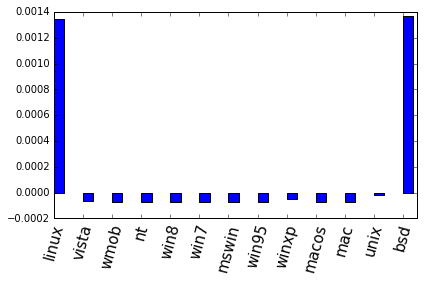

In [22]:
#IMPACT FACTOR!

import numpy as np

os = [15535,1566,8891,15739,18143,18145,18332,23831,25400,10644,12128,21769,25110]
names = ['linux', 'vista', 'wmob', 'nt', 'win8', 'win7', 'mswin', 'win95', 'winxp','macos','mac','unix','bsd']

print np.mean(out)

plt.bar(range(len(os)),[out[i] - np.mean(out) for i in os ], 0.35)
plt.xticks(range(len(os)), names,size=15, rotation=75)
plt.xlim(0,12.5)
#plt.ylim(0.1995,0.202)
plt.tight_layout()


## OS and Apple

In [39]:
find_node(G, "operating")

http://dbpedia.org/resource/Fedora_(operating_system) 2245
http://dbpedia.org/resource/Solaris_(operating_system) 3533
http://dbpedia.org/resource/Android_(operating_system) 5510
http://dbpedia.org/resource/Chief_operating_officer 10795
http://dbpedia.org/resource/Southern_(train_operating_company) 23993
http://dbpedia.org/resource/Operating_system 24265


converting to CSR
A: (29477, 29477)
B: (29477,)
D: (29477, 29477)
y: (29477,)
I: (29477, 29477)
converted
currently at itr: 0


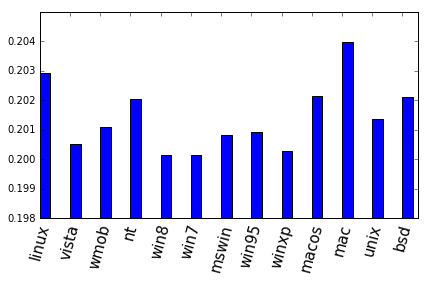

In [40]:
eta = 0.5

plt.figure(figsize=(8,6))

mgs = []

for i in range(1):

    N = len(A.todense())
    w = 1./N
    pi = 0.2

    l_pos=[19337,24265]
    l_neg=[]
    #l_neg=[19337]
    l_warm=[]


    search = AS(A, N, eta, w, pi ,l_pos, l_neg, l_warm, amg=True)
    output, out = search_test_new_nofb(search,G ,itr=1)
    
    eta= eta-0.08

%matplotlib inline
os = [15535,1566,8891,15739,18143,18145,18332,23831,25400,10644,12128,21769,25110]
names = ['linux', 'vista', 'wmob', 'nt', 'win8', 'win7', 'mswin', 'win95', 'winxp','macos','mac','unix','bsd']

plt.bar(range(len(os)),[out[i] for i in os ], 0.35)
plt.xticks(range(len(os)), names,size=15, rotation=75)

plt.ylim(0.198,0.205)
plt.xlim(0,12.5)

plt.tight_layout()


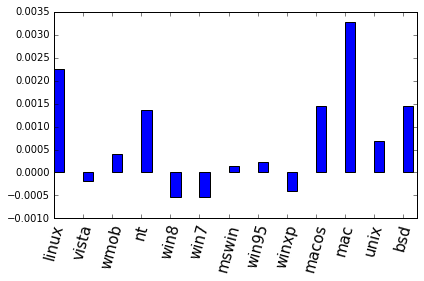

In [41]:
#impact factor
%matplotlib inline
os = [15535,1566,8891,15739,18143,18145,18332,23831,25400,10644,12128,21769,25110]
names = ['linux', 'vista', 'wmob', 'nt', 'win8', 'win7', 'mswin', 'win95', 'winxp','macos','mac','unix','bsd']

plt.bar(range(len(os)),[out[i] - np.mean(out) for i in os ], 0.35)
plt.xticks(range(len(os)), names,size=15, rotation=75)

#plt.ylim(0.198,0.205)
plt.xlim(0,12.5)

plt.tight_layout()



In [69]:
na = np.array([  (i - np.mean(out)) for i in out])
na[l_pos+l_neg] = 0
na[20274] = 0
na[6762] = 0
na[20867] = 0
na[23871] = 0
na[27954] = 0
na[19535] = 0
na[24973] = 0

print np.argmax(na)


27508


In [70]:
print G.nodes()[np.argmax(na)], G[G.nodes()[np.argmax(na)]]

Is there anybody who has (or can point me in the right direction) any
information about protected mode? Also interested in protected mode viewed from
a OS point of view. {u'http://dbpedia.org/resource/Operating_system': {'weight': 1.0}}


## OS and Gaming

converting to CSR
A: (29477, 29477)
B: (29477,)
D: (29477, 29477)
y: (29477,)
I: (29477, 29477)
converted
currently at itr: 0


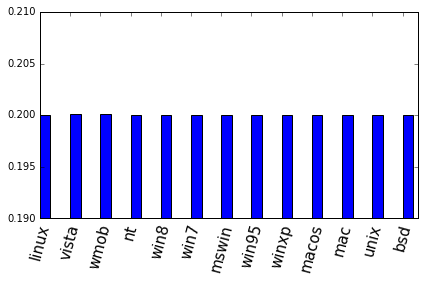

In [80]:
eta = 0.5


mgs = []

for i in range(1):

    N = len(A.todense())
    w = 1./N
    pi = 0.2

    l_pos=[4562,]
    l_neg=[]
    #l_neg=[19337]
    l_warm=[]


    search = AS(A, N, eta, w, pi ,l_pos, l_neg, l_warm, amg=True)
    output, out = search_test_new_nofb(search,G ,itr=1)
    
    eta= eta-0.08

%matplotlib inline
os = [15535,1566,8891,15739,18143,18145,18332,23831,25400,10644,12128,21769,25110]
plt.bar(range(len(os)),[out[i] for i in os ], 0.35)
plt.xticks(range(len(os)), names,size=15, rotation=75)

plt.ylim(0.19,0.21)
plt.xlim(0,12.5)

plt.tight_layout()


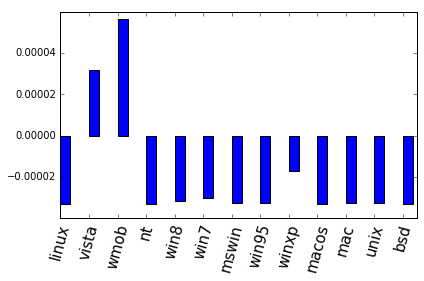

In [81]:
%matplotlib inline
os = [15535,1566,8891,15739,18143,18145,18332,23831,25400,10644,12128,21769,25110]
plt.bar(range(len(os)),[out[i] - np.mean(out) for i in os ], 0.35)
plt.xticks(range(len(os)), names,size=15, rotation=75)

#plt.ylim(0.19995,0.2001)
plt.xlim(0,12.5)

plt.tight_layout()


In [16]:
find_node(G, "video")

http://dbpedia.org/resource/Video_game_publisher 2860
http://dbpedia.org/resource/Racing_video_game 3141
http://dbpedia.org/resource/Puzzle_video_game 3508
http://dbpedia.org/resource/Side-scrolling_video_game 4479
http://dbpedia.org/resource/Video_game 4562
http://dbpedia.org/resource/Mod_(video_gaming) 5682
http://dbpedia.org/resource/Music_video 5736
http://dbpedia.org/resource/Video 7751
http://dbpedia.org/resource/Single-player_video_game 8807
http://dbpedia.org/resource/List_of_Sonic_the_Hedgehog_video_game_characters 10137
http://dbpedia.org/resource/Final_Fantasy_(video_game) 13031
http://dbpedia.org/resource/Video_on_demand 14363
http://dbpedia.org/resource/Video_Graphics_Array 17038
http://dbpedia.org/resource/DVD-Video 17458
http://dbpedia.org/resource/Doom_(video_game) 17958
http://dbpedia.org/resource/MTV_Video_Music_Award 19093
http://dbpedia.org/resource/Boss_(video_gaming) 19442
http://dbpedia.org/resource/Videotape 20206
http://dbpedia.org/resource/Digital_video_record

# OS and Gaming Normalised

converting to CSR
A: (29477, 29477)
B: (29477,)
D: (29477, 29477)
y: (29477,)
I: (29477, 29477)
converted
currently at itr: 0
converting to CSR
A: (29477, 29477)
B: (29477,)
D: (29477, 29477)
y: (29477,)
I: (29477, 29477)
converted
currently at itr: 0


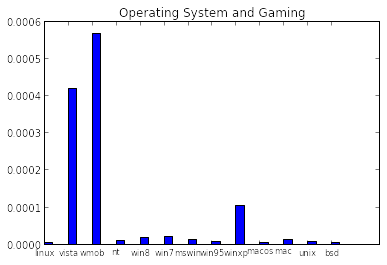

In [82]:
%matplotlib inline


eta = 0.5
N = len(A.todense())
w = 1./N
pi = 0.2

l_pos=[2860,4562,8807,23493]
l_neg=[]

l_warm=[]


search = AS(A, N, eta, w, pi ,l_pos, l_neg, l_warm, amg=True)
output, out = search_test_new_nofb(search,G ,itr=1)
    
os = [15535,1566,8891,15739,18143,18145,18332,23831,25400,10644,12128,21769,25110]
names = ['linux', 'vista', 'wmob', 'nt', 'win8', 'win7', 'mswin', 'win95', 'winxp','macos','mac','unix','bsd']

vals = [out[i] for i in os ]

l_pos, l_neg = l_neg, l_pos

search = AS(A, N, eta, w, pi ,l_pos, l_neg, l_warm, amg=True)
output, out = search_test_new_nofb(search,G ,itr=1)
    

vals = [(vals[i] - out[os[i]])/vals[i] for i in range(len(os)) ]


plt.bar(range(len(os)),vals, 0.35)
plt.xticks(range(len(os)), names,size='small')

#plt.ylim(0.1995,0.2006)
plt.title("Operating System and Gaming")

# OS and Apple Normalised

converting to CSR
A: (29477, 29477)
B: (29477,)
D: (29477, 29477)
y: (29477,)
I: (29477, 29477)
converted
currently at itr: 0
converting to CSR
A: (29477, 29477)
B: (29477,)
D: (29477, 29477)
y: (29477,)
I: (29477, 29477)
converted
currently at itr: 0


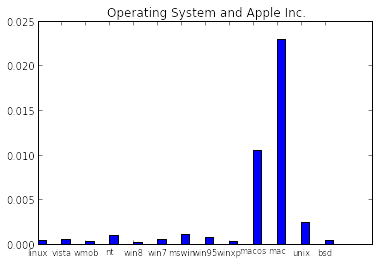

In [83]:
%matplotlib inline


eta = 0.5
N = len(A.todense())
w = 1./N
pi = 0.2

l_pos=[19337]
l_neg=[]

l_warm=[]


search = AS(A, N, eta, w, pi ,l_pos, l_neg, l_warm, amg=True)
output, out = search_test_new_nofb(search,G ,itr=1)
    
os = [15535,1566,8891,15739,18143,18145,18332,23831,25400,10644,12128,21769,25110]
names = ['linux', 'vista', 'wmob', 'nt', 'win8', 'win7', 'mswin', 'win95', 'winxp','macos','mac','unix','bsd']

vals = [out[i] for i in os ]

l_pos, l_neg = l_neg, l_pos

search = AS(A, N, eta, w, pi ,l_pos, l_neg, l_warm, amg=True)
output, out = search_test_new_nofb(search,G ,itr=1)
    

vals = [(vals[i] - out[os[i]])/vals[i] for i in range(len(os)) ]


plt.bar(range(len(os)),vals, 0.35)
plt.xticks(range(len(os)), names,size='small')

#plt.ylim(0.1995,0.2006)
plt.title("Operating System and Apple Inc.")

# OS and Open Source Normalised

converting to CSR
A: (29477, 29477)
B: (29477,)
D: (29477, 29477)
y: (29477,)
I: (29477, 29477)
converted
currently at itr: 0
converting to CSR
A: (29477, 29477)
B: (29477,)
D: (29477, 29477)
y: (29477,)
I: (29477, 29477)
converted
currently at itr: 0


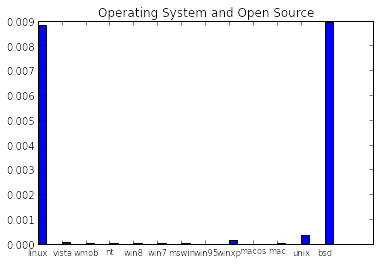

In [131]:
%matplotlib inline


eta = 0.5
N = len(A.todense())
w = 1./N
pi = 0.2

l_pos=[13575,21477]
l_neg=[]

l_warm=[]


search = AS(A, N, eta, w, pi ,l_pos, l_neg, l_warm, amg=True)
output, out = search_test_new_nofb(search,G ,itr=1)
    
os = [15535,1566,8891,15739,18143,18145,18332,23831,25400,10644,12128,21769,25110]
names = ['linux', 'vista', 'wmob', 'nt', 'win8', 'win7', 'mswin', 'win95', 'winxp','macos','mac','unix','bsd']

vals = [out[i] for i in os ]

l_pos, l_neg = l_neg, l_pos

search = AS(A, N, eta, w, pi ,l_pos, l_neg, l_warm, amg=True)
output, out = search_test_new_nofb(search,G ,itr=1)
    

vals = [(vals[i] - out[os[i]])/vals[i] for i in range(len(os)) ]


plt.bar(range(len(os)),vals, 0.35)
plt.xticks(range(len(os)), names,size='small')

#plt.ylim(0.1995,0.2006)
plt.title("Operating System and Open Source ")

converting to CSR
A: (29477, 29477)
B: (29477,)
D: (29477, 29477)
y: (29477,)
I: (29477, 29477)
converted
currently at itr: 0


(0.1995, 0.2025)

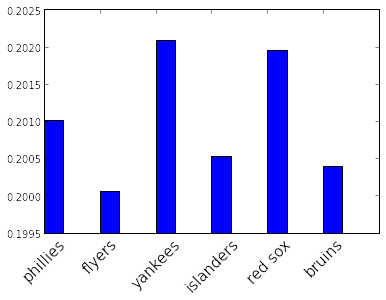

In [53]:
%matplotlib inline


eta = 0.5
N = len(A.todense())
w = 1./N
pi = 0.2

l_pos=[ 14520,11260]
l_neg=[]

l_warm=[]


search = AS(A, N, eta, w, pi ,l_pos, l_neg, l_warm, amg=True)
output, out = search_test_new_nofb(search,G ,itr=1)
    
os = [6589,6297,12052,91,19443,16784]
names = ['phillies',  'flyers', 'yankees', 'islanders', 'red sox', 'bruins' ]

vals = [out[i] for i in os ]

l_pos, l_neg = l_neg, l_pos

#search = AS(A, N, eta, w, pi ,l_pos, l_neg, l_warm, amg=True)
#output, out = search_test_new_nofb(search,G ,itr=1)
    

#vals = [(vals[i] - out[os[i]])/vals[i] for i in range(len(os)) ]
plt.figure

plt.bar(range(len(os)),vals, 0.35)
plt.xticks(range(len(os)), names,size=15, rotation=45)

plt.ylim(0.1995,0.2025)


converting to CSR
A: (29477, 29477)
B: (29477,)
D: (29477, 29477)
y: (29477,)
I: (29477, 29477)
converted
currently at itr: 0
converting to CSR
A: (29477, 29477)
B: (29477,)
D: (29477, 29477)
y: (29477,)
I: (29477, 29477)
converted
currently at itr: 0


<Container object of 6 artists>

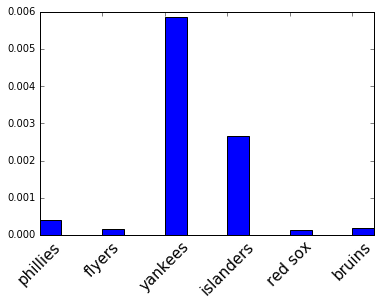

In [83]:
%matplotlib inline


eta = 0.5
N = len(A.todense())
w = 1./N
pi = 0.2

l_pos=[11260]
l_neg=[]

l_warm=[]


search = AS(A, N, eta, w, pi ,l_pos, l_neg, l_warm, amg=True)
output, out = search_test_new_nofb(search,G ,itr=1)
    
os = [6589,6297,12052,91,19443,16784]
names = ['phillies',  'flyers', 'yankees', 'islanders', 'red sox', 'bruins' ]

vals = [out[i] for i in os ]

l_pos, l_neg = l_neg, l_pos

search = AS(A, N, eta, w, pi ,l_pos, l_neg, l_warm, amg=True)
output, out = search_test_new_nofb(search,G ,itr=1)
    

vals = [(vals[i] - out[os[i]])/vals[i] for i in range(len(os)) ]
plt.xticks(range(len(os)), names,size=15, rotation=45)


plt.bar(range(len(os)),vals, 0.35)

#plt.ylim(0.1998,0.2010)


converting to CSR
A: (29477, 29477)
B: (29477,)
D: (29477, 29477)
y: (29477,)
I: (29477, 29477)
converted
currently at itr: 0


<Container object of 6 artists>

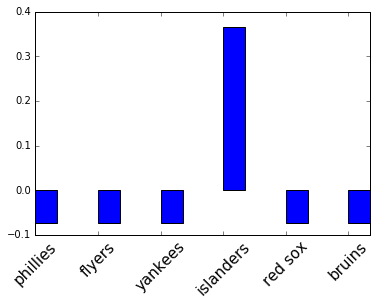

In [110]:
%matplotlib inline


eta = 0.5
N = len(A.todense())
w = 1./N
pi = 0.2

l_pos=[91]
#l_pos = []
l_neg=[]

l_warm=[]


search = AS(A, N, eta, w, pi ,l_pos, l_neg, l_warm, amg=True)
output, out = search_test_new_nofb(search,G ,itr=1)
    
os = [6589,6297,12052,91,19443,16784]
names = ['phillies',  'flyers', 'yankees', 'islanders', 'red sox', 'bruins' ]

vals = [out[i] for i in os ]
plt.xticks(range(len(os)), names,size=15, rotation=45)
#plt.ylim(0.1998,0.2010)
plt.bar(range(len(os)),[val - np.mean(vals) for val in vals], 0.35)


In [114]:
#find_node(G, "york")

In [112]:
def IF(out, labelled):
    import numpy as np
    
    out = np.delete(out, labelled)
    return np.sum(out*(1-out))

In [115]:
print IF(vals, l_pos+l_neg)

1.03099496084


In [197]:
find_node(G, "york")

http://dbpedia.org/resource/New_York_Islanders 91
http://dbpedia.org/resource/Cape_York_Peninsula 240
http://dbpedia.org/resource/New_York_Knicks 1200
http://dbpedia.org/resource/Ithaca,_New_York 1426
http://dbpedia.org/resource/New_York_Jets 1782
http://dbpedia.org/resource/York 2289
http://dbpedia.org/resource/Buffalo,_New_York 2867
http://dbpedia.org/resource/Hudson,_New_York 3691
http://dbpedia.org/resource/New_York_metropolitan_area 4809
http://dbpedia.org/resource/Binghamton,_New_York 4842
http://dbpedia.org/resource/Monroe_County,_New_York 5711
http://dbpedia.org/resource/New_York_Mets 6199
http://dbpedia.org/resource/Westchester_County,_New_York 7145
http://dbpedia.org/resource/The_New_York_Times 7347
http://dbpedia.org/resource/Western_New_York 7766
http://dbpedia.org/resource/Port_Authority_of_New_York_and_New_Jersey 8005
http://dbpedia.org/resource/Albany,_New_York 8334
http://dbpedia.org/resource/Lake_Placid,_New_York 8462
http://dbpedia.org/resource/York,_Pennsylvania 8655

In [204]:
print G.nodes()[ 23314]
print G.nodes()[11260]

http://dbpedia.org/resource/Ice_hockey
http://dbpedia.org/resource/New_York_City


converting to CSR
A: (29477, 29477)
B: (29477,)
D: (29477, 29477)
y: (29477,)
I: (29477, 29477)
converted
currently at itr: 0
converting to CSR
A: (29477, 29477)
B: (29477,)
D: (29477, 29477)
y: (29477,)
I: (29477, 29477)
converted
currently at itr: 0


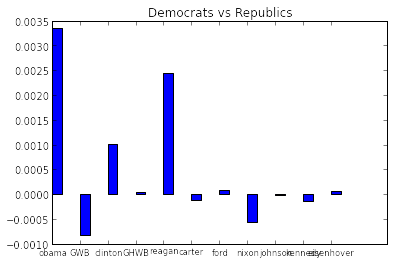

In [115]:
%matplotlib inline


eta = 0.5
N = len(A.todense())
w = 1./N
pi = 0.2

l_pos=[13960]
l_neg=[15305]

l_warm=[]


search = AS(A, N, eta, w, pi ,l_pos, l_neg, l_warm, amg=True)
output, out = search_test_new_nofb(search,G ,itr=1)
    
os = [15150,4292,13881,8570,16402,12692,15471,21828,10597,1439,17623]
names = ['obama', 'GWB', 'clinton','GHWB','reagan','carter','ford','nixon','johnson','kennedy','eisenhover']

vals = [out[i] for i in os ]

l_pos, l_neg = l_neg, l_pos

search = AS(A, N, eta, w, pi ,l_pos, l_neg, l_warm, amg=True)
output, out = search_test_new_nofb(search,G ,itr=1)
    

vals = [(vals[i] - out[os[i]])/vals[i] for i in range(len(os)) ]


plt.bar(range(len(os)),vals, 0.35)
plt.xticks(range(len(os)), names,size='small')

#plt.ylim(0.1995,0.2006)
plt.title("Democrats vs Republics")

In [107]:
n = 0
for item in os:
    print G.nodes()[item],  names[n]
    n+=1

http://dbpedia.org/resource/Barack_Obama obama
http://dbpedia.org/resource/George_W._Bush GWB
http://dbpedia.org/resource/Bill_Clinton clinton
http://dbpedia.org/resource/George_H._W._Bush GHWB
http://dbpedia.org/resource/Ronald_Reagan reagan
http://dbpedia.org/resource/Jimmy_Carter carter
http://dbpedia.org/resource/Gerald_Ford ford
http://dbpedia.org/resource/Richard_Nixon nixon
http://dbpedia.org/resource/Lyndon_B._Johnson johnson
http://dbpedia.org/resource/John_F._Kennedy kennedy
http://dbpedia.org/resource/Dwight_D._Eisenhower eisenhover


In [24]:
out[10644]

0.2000009828374506

(0.195, 0.205)

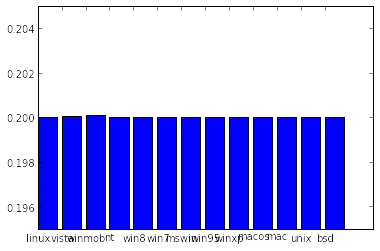

In [25]:
os = [15535,1566,8891,15739,18143,18145,18332,23831,25400,10644,12128,21769,25110]
names = ['linux', 'vista', 'winmob', 'nt', 'win8', 'win7', 'mswin', 'win95', 'winxp','macos','mac','unix','bsd']

plt.bar(range(len(os)),[out[i] for i in os ])
plt.xticks(range(len(os)), names)

plt.ylim(0.195,0.205)